<a href="https://colab.research.google.com/github/JeJaMel/AI_Facial_Expressions_Recognicion/blob/main/Facial_expressions_recognicion_IA_FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyngrok streamlit

In [2]:
import tensorflow as tf
from tensorflow import keras
tf.test.gpu_device_name() #this line is for test if T4 GPUT is beeing used (recomend)
import kagglehub
from google.colab import drive
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import layers
import pandas as pd
import cv2
from tensorflow.keras import mixed_precision, callbacks, models
from tensorflow.keras.callbacks import ModelCheckpoint
import streamlit as st
from pyngrok import ngrok
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp -r /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1 /content/drive/MyDrive/FERDataSet #Move the dataset to the drive

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def prepare_fer2013_data(data_dir, img_size=(48, 48), batch_size=64):

    train_dir = os.path.join(data_dir, 'train')
    validation_dir = os.path.join(data_dir, 'test')

    # Data augmentation for training data
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Only rescaling for validation data
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        color_mode='grayscale',  # FER-2013 is grayscale
        class_mode='categorical'
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=img_size,
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical'
    )

    return train_generator, validation_generator




In [9]:
data_directory = '/content/drive/MyDrive/FERDataSet'
train_gen, val_gen = prepare_fer2013_data(data_directory)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_light_cnn(input_shape=(48, 48, 1), num_classes=7):

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), # Add dropout for regularization
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Example usage (after creating train_gen and val_gen):
input_shape = (48, 48, 1) # Grayscale
num_classes = 7



In [ ]:
model = create_light_cnn(input_shape, num_classes)


In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [10]:
model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [13]:
checkpoint_filepath = os.path.join(model_dir, 'best_model.h5')
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy', #or val_loss, depending on what you want to monitor.
    mode='max' # or min, depending on monitor
)

In [14]:
early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_accuracy', # or val_loss
    patience=10,
    restore_best_weights=True
)

In [18]:
tf.config.run_functions_eagerly(True)

In [ ]:
history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen)
)

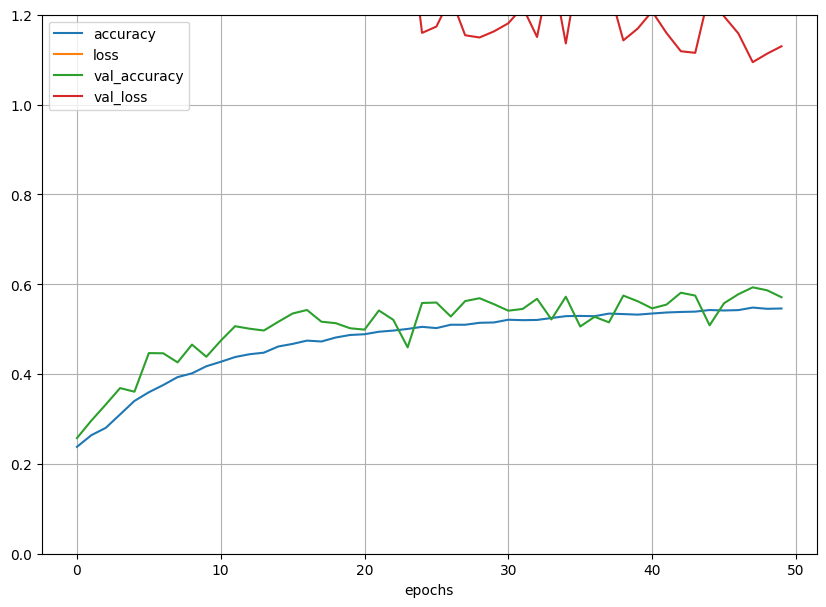

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_training_history(history):

    if history is None or not hasattr(history, 'history'):
        print("Invalid history object. Make sure you passed the history object from model.fit()")
        return

    df = pd.DataFrame(history.history)
    df.plot(figsize=(10, 7))
    plt.grid(True)
    plt.gca().set_ylim(0, 1.2)  # Adjust y-axis limits as needed
    plt.xlabel("epochs")
    plt.show()

# Example usage (after training your model):
# Assuming your training history is stored in the 'history' variable:
plot_training_history(history)

In [11]:
model = load_model('/content/best_modelV4.h5')

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import cv2 # Import OpenCV

def predict_emotion(model, img_path, target_size=(48, 48), class_names=None):
    try:
        img = cv2.imread(img_path) #Load using cv2, to handle color
        if img is None:
            raise FileNotFoundError(f"Could not read image at {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grayscale
        img = cv2.resize(img, target_size)
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return
    except Exception as e:
        print(f"Error loading/processing image: {e}")
        return

    try:
        predictions = model.predict(img)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return

    predicted_class = np.argmax(predictions)
    score = predictions[0][predicted_class]

    plt.figure(figsize=(3, 3))
    plt.imshow(img[0], cmap='gray')  # Display as grayscale
    if class_names:
        plt.title(f"{class_names[predicted_class]}, Confidence: {100 * score:.2f}%")
    else:
        plt.title(f"Predicted Emotion: {predicted_class}, Confidence: {100 * score:.2f}%")

    plt.axis("off")
    plt.show()



In [ ]:
img_path = '/content/'
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
target_size = (48, 48)

predict_emotion(model, img_path, target_size, class_names)

In [ ]:
ngrok.set_auth_token("TOKEN")

# Configure the tunnel using a config object
tunnel = ngrok.connect(addr="8501", proto="http", bind_tls=True)  # Streamlit's default port

public_url = tunnel.public_url
print(f"Public URL: {public_url}")

# Start the Streamlit server, pointing to your script file
!streamlit run --server.port 8501 /content/drive/MyDrive/FERDataSet/Scripts/main.py &